In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

IMAGE_SIZE = (128, 128)
channels = 3
classes = 3
batch_size = 64

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.one_hot(tf.cast(tf.cast(input_mask, tf.int64) - 1, tf.uint8), depth=3)
    input_mask = tf.squeeze(input_mask, axis=-2)  # Remove the extra dimension
    return input_image, input_mask




# Load Oxford-IIIT Pet dataset
builder = tfds.builder('oxford_iiit_pet:3.2.0')
config = tfds.download.DownloadConfig(register_checksums=True)
builder.download_and_prepare(download_config=config)
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

# Train dataset
train_dataset = dataset['train'].map(
    lambda x: (tf.image.resize(x['image'], IMAGE_SIZE), tf.image.resize(x['segmentation_mask'], IMAGE_SIZE)),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).map(normalize).cache().shuffle(buffer_size=1000).take(info.splits["train"].num_examples)




# Test dataset
test_dataset = dataset['test'].map(
    lambda x: (tf.image.resize(x['image'], IMAGE_SIZE), tf.image.resize(x['segmentation_mask'], IMAGE_SIZE))
).map(normalize).batch(batch_size)  # Include batching




SyntaxError: unmatched ')' (<ipython-input-12-f7bb198bbfa7>, line 33)

In [ ]:
import matplotlib.pyplot as plt

# Display a few images from the training dataset
for image, mask in train_dataset.take(3):
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title('Original Image')

    # Display the segmentation mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy().squeeze(), cmap='viridis')  # Assuming mask is single-channel
    plt.title('Segmentation Mask')

    plt.show()


In [ ]:
inputs= tf.keras.layers.Input(shape=(128, 128, 3))
c1=tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same',input_shape=(128, 128, 3))(inputs)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D()(c1)

c2=tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
c2=tf.keras.layers.Dropout(0.2)(c2)
c2=tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D()(c2)


c3=tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
c3=tf.keras.layers.Dropout(0.3)(c3)
c3=tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c3)



u1=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2), padding='same')(c3)
u1=tf.keras.layers.concatenate([u1,c2])
c4=tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
c4=tf.keras.layers.Dropout(0.3)(c4)
c4=tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

u2=tf.keras.layers.Conv2DTranspose(64,(2,2) ,strides=(2,2), padding='same')(c4)
u2=tf.keras.layers.concatenate([u2,c1])
c5=tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
c5=tf.keras.layers.Dropout(0.2)(c5)
c5=tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

outputs=tf.keras.layers.Conv2D(3, 1, activation='softmax')(c5)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()


In [ ]:

train_dataset_batched = train_dataset.batch(batch_size)

# Train the model with the batched dataset


for batch in train_dataset_batched.take(1):
    print("Batch Shape:", batch[0].shape, batch[1].shape)

for example in train_dataset_batched.take(3):
    print("Input Shape:", example[0].shape, "Mask Shape:", example[1].shape)
for batch_images, batch_labels in train_dataset_batched.take(1):
    print("Batch Shape:", batch_images.shape, batch_labels.shape)


In [10]:



model.fit(train_dataset_batched, epochs=10)
# Evaluate the model on the test dataset

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")




Epoch 1/10
58/58 [==============================] - 42s 609ms/step - loss: 0.8713 - accuracy: 0.5996
Epoch 2/10
58/58 [==============================] - 36s 622ms/step - loss: 0.7295 - accuracy: 0.6811
Epoch 3/10
58/58 [==============================] - 35s 607ms/step - loss: 0.6782 - accuracy: 0.7043
Epoch 4/10
58/58 [==============================] - 36s 615ms/step - loss: 0.6401 - accuracy: 0.7255
Epoch 5/10
58/58 [==============================] - 35s 610ms/step - loss: 0.6277 - accuracy: 0.7386
Epoch 6/10
58/58 [==============================] - 35s 610ms/step - loss: 0.5776 - accuracy: 0.7643
Epoch 7/10
58/58 [==============================] - 35s 611ms/step - loss: 0.5277 - accuracy: 0.7882
Epoch 8/10
58/58 [==============================] - 36s 612ms/step - loss: 0.5014 - accuracy: 0.8012
Epoch 9/10
58/58 [==============================] - 35s 611ms/step - loss: 0.4925 - accuracy: 0.8052
Epoch 10/10
58/58 [==============================] - 13s 210ms/step - loss: 0.4592 - accura

2/2 [==============================] - 0s 94ms/step


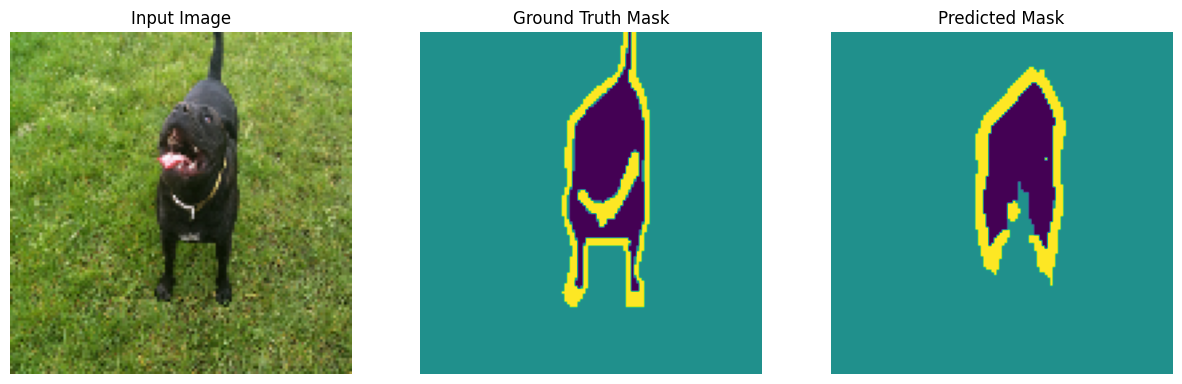

2/2 [==============================] - 0s 64ms/step


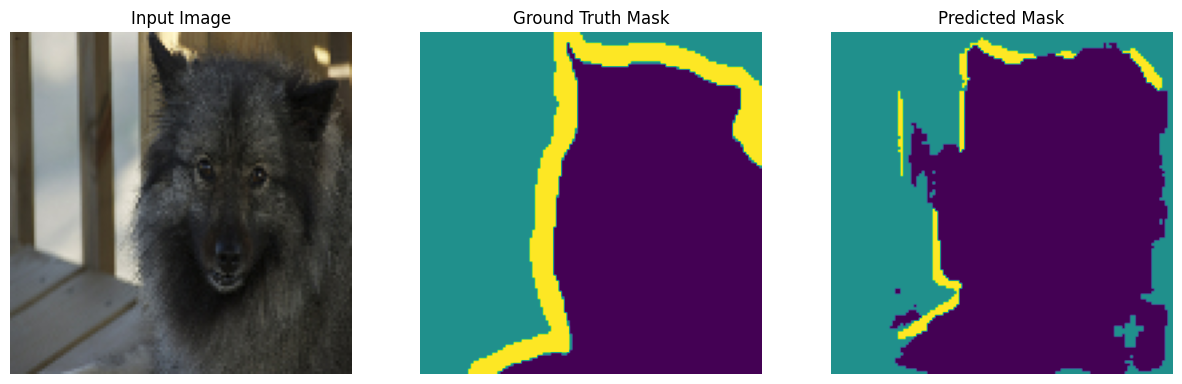

2/2 [==============================] - 0s 61ms/step


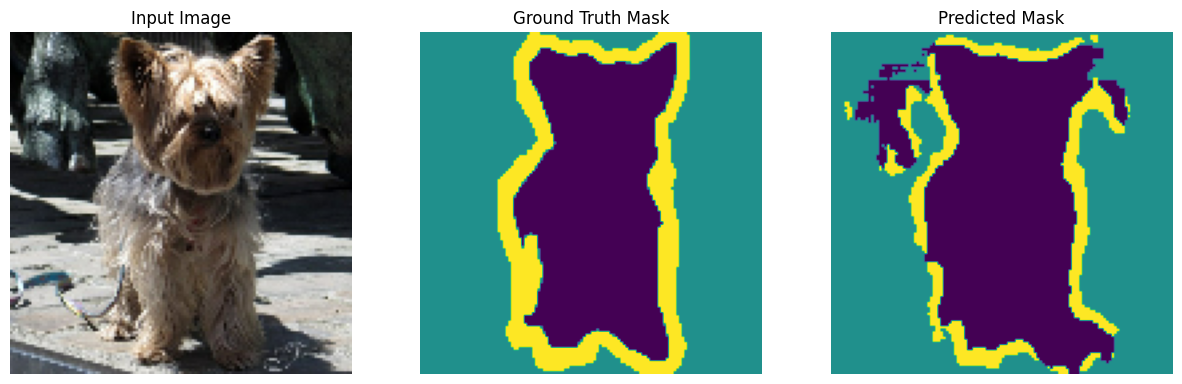

In [13]:

import random

# Choose random examples from the test dataset for prediction
num_examples = 3
test_examples = test_dataset.shuffle(buffer_size=1000).take(num_examples)

# Make predictions
for example in test_examples:
    input_image, target_mask = example
    predictions = model.predict(input_image)

    # Display the results
    plt.figure(figsize=(15, 5))

    # Display the input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image[0])
    plt.title("Input Image")
    plt.axis("off")

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(tf.argmax(target_mask[0], axis=-1), )
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(tf.argmax(predictions[0], axis=-1), )
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()
